[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/02a-pasient_likhetsnettverk_iris_losninger.ipynb)


Versjon 2025.12.02 - A. Lundervold

# Løsninger: Pasient-likhetsnettverk med IRIS-data

**Dette er løsningsnotebooken til `02-pasient_likhetsnettverk_iris.ipynb`.**

Her finner du fullstendige løsninger med forklaringer og kommentert kode for alle 10 øvelser.


---
## Oppsett: Last inn data og bygg grunnleggende nettverk

Først kjører vi oppsettet fra hovednotebooken slik at vi har data og nettverk tilgjengelig.


In [8]:
# ============================================================
# OPPSETT - Kjør denne cellen først!
# ============================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import community.community_louvain as community_louvain
from scipy.spatial.distance import cityblock
import random

# Last inn IRIS-data
iris = load_iris()
X = iris.data
y = iris.target
species = iris.target_names

# Bygg grunnleggende nettverk (som i hovednotebooken)
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, species=species[y[i]])

for i in range(len(X)):
    for j in range(i+1, len(X)):
        distance = np.linalg.norm(X[i] - X[j])
        similarity = 1 / (1.0 + distance)
        G.add_edge(i, j, weight=similarity)

# Beregn layout (gjenbrukes i flere øvelser)
pos = nx.spring_layout(G, k=1, seed=42)

# Kjør community detection på grunnleggende nettverk
communities_original = community_louvain.best_partition(G)

# Farger
species_colors = {'setosa': '#E63946', 'versicolor': '#FFD700', 'virginica': '#457B9D'}

print("✓ Oppsett fullført!")
print(f"  • {G.number_of_nodes()} noder, {G.number_of_edges()} kanter")
print(f"  • {len(set(communities_original.values()))} communities detektert")


✓ Oppsett fullført!
  • 150 noder, 11175 kanter
  • 3 communities detektert


---
## Øvelse 1: Alternativ likhetsmål – Gaussisk kjerne ⭐

### Oppgave
Modifiser koden til å bruke Gaussisk kjerne (RBF):
$$s_{ij} = \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right)$$

### Løsning

Gaussisk kjerne (også kalt RBF - Radial Basis Function) er et populært likhetsmål fordi:
- Det gir verdier mellom 0 og 1
- Likheten avtar eksponentielt med avstanden
- $\sigma$ kontrollerer "bredden" – hvor raskt likheten faller av


ØVELSE 1: Gaussisk kjerne med ulike sigma-verdier

σ = 0.5:
  • Antall communities: 4
  • ARI (vs. faktiske arter): 0.676
  • Gjennomsnittlig similarity: 0.117

σ = 1.0:
  • Antall communities: 3
  • ARI (vs. faktiske arter): 0.730
  • Gjennomsnittlig similarity: 0.280

σ = 2.0:
  • Antall communities: 2
  • ARI (vs. faktiske arter): 0.523
  • Gjennomsnittlig similarity: 0.509

σ = 5.0:
  • Antall communities: 2
  • ARI (vs. faktiske arter): 0.507
  • Gjennomsnittlig similarity: 0.847


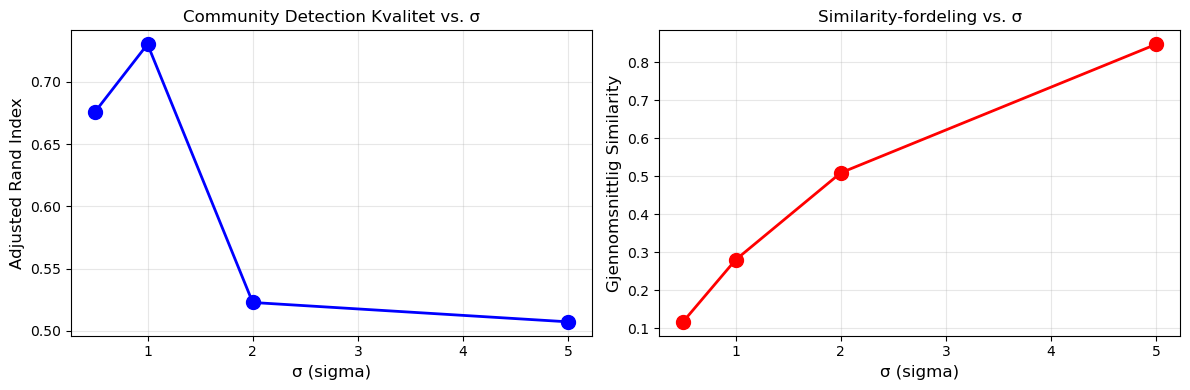


KONKLUSJON:

• Liten σ (0.5): Kun svært nære noder får høy likhet. Kan gi mange små communities.
• Medium σ (1.0-2.0): Balansert - gir ofte beste community detection.
• Stor σ (5.0): Alle noder får relativt lik similarity. Mister diskriminerende evne.

For IRIS-data ser vi at σ ≈ 1-2 gir best ARI, noe som tilsvarer typisk 
inter-punkt avstand i datasettet.



In [9]:
# Øvelse 1: Gaussisk kjerne med ulike sigma-verdier

def build_gaussian_network(X, y, species, sigma):
    """
    Bygg nettverk med Gaussisk kjerne som likhetsmål.
    
    Formel: s_ij = exp(-d_ij^2 / (2 * sigma^2))
    """
    G_gauss = nx.Graph()
    
    # Legg til noder
    for i in range(len(X)):
        G_gauss.add_node(i, species=species[y[i]])
    
    # Legg til kanter med Gaussisk likhet
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            # Beregn Euklidsk avstand
            distance = np.linalg.norm(X[i] - X[j])
            
            # Gaussisk kjerne: exp(-d^2 / (2*sigma^2))
            similarity = np.exp(-(distance**2) / (2 * sigma**2))
            
            G_gauss.add_edge(i, j, weight=similarity)
    
    return G_gauss

# Test med ulike sigma-verdier
sigmas = [0.5, 1.0, 2.0, 5.0]
results = []

print("="*60)
print("ØVELSE 1: Gaussisk kjerne med ulike sigma-verdier")
print("="*60)

for sigma in sigmas:
    # Bygg nettverk
    G_gauss = build_gaussian_network(X, y, species, sigma)
    
    # Community detection
    communities_gauss = community_louvain.best_partition(G_gauss)
    n_comm = len(set(communities_gauss.values()))
    
    # Beregn ARI mot faktiske arter
    ari = adjusted_rand_score(y, list(communities_gauss.values()))
    
    # Beregn gjennomsnittlig similarity
    avg_sim = np.mean([G_gauss[u][v]['weight'] for u, v in G_gauss.edges()])
    
    results.append({
        'sigma': sigma,
        'n_communities': n_comm,
        'ari': ari,
        'avg_similarity': avg_sim
    })
    
    print(f"\nσ = {sigma}:")
    print(f"  • Antall communities: {n_comm}")
    print(f"  • ARI (vs. faktiske arter): {ari:.3f}")
    print(f"  • Gjennomsnittlig similarity: {avg_sim:.3f}")

# Visualiser resultatene
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ARI vs sigma
ax1 = axes[0]
ax1.plot([r['sigma'] for r in results], [r['ari'] for r in results], 'bo-', linewidth=2, markersize=10)
ax1.set_xlabel('σ (sigma)', fontsize=12)
ax1.set_ylabel('Adjusted Rand Index', fontsize=12)
ax1.set_title('Community Detection Kvalitet vs. σ', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot avg similarity vs sigma
ax2 = axes[1]
ax2.plot([r['sigma'] for r in results], [r['avg_similarity'] for r in results], 'ro-', linewidth=2, markersize=10)
ax2.set_xlabel('σ (sigma)', fontsize=12)
ax2.set_ylabel('Gjennomsnittlig Similarity', fontsize=12)
ax2.set_title('Similarity-fordeling vs. σ', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KONKLUSJON:")
print("="*60)
print("""
• Liten σ (0.5): Kun svært nære noder får høy likhet. Kan gi mange små communities.
• Medium σ (1.0-2.0): Balansert - gir ofte beste community detection.
• Stor σ (5.0): Alle noder får relativt lik similarity. Mister diskriminerende evne.

For IRIS-data ser vi at σ ≈ 1-2 gir best ARI, noe som tilsvarer typisk 
inter-punkt avstand i datasettet.
""")


---
## Øvelse 2: Terskelbasert glissent nettverk

### Oppgave
Bygg et glissent (sparse) nettverk der kun kanter med likhet over en terskel inkluderes.

### Løsning

Et glissent nettverk inneholder kun de viktigste forbindelsene. Dette har flere fordeler:
- Raskere beregninger - færre kanter å prosessere
- Klarere struktur - støyen filtreres vekk
- Bedre visualisering - lettere å se mønstre


ØVELSE 2: Terskelbaserte glissne nettverk

Terskel = 0.3:
  • Kanter: 5,553 (49.7% av komplett)
  • Nettverkstetthet: 0.4969
  • Communities: 2
  • ARI: 0.558

Terskel = 0.5:
  • Kanter: 2,637 (23.6% av komplett)
  • Nettverkstetthet: 0.2360
  • Communities: 3
  • ARI: 0.868

Terskel = 0.7:
  • Kanter: 520 (4.7% av komplett)
  • Nettverkstetthet: 0.0465
  • Communities: 21
  • ARI: 0.436


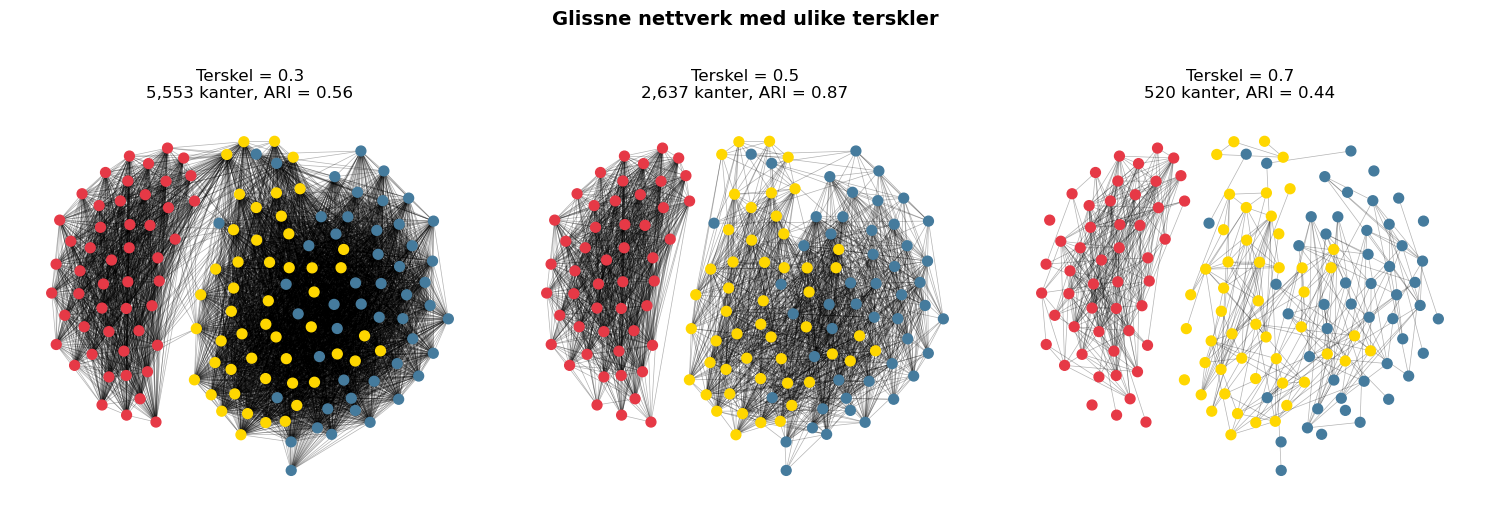


OPPSUMMERING:
 threshold  n_edges  density  n_communities      ari
       0.3     5553 0.496913              2 0.558371
       0.5     2637 0.235973              3 0.868111
       0.7      520 0.046532             21 0.436473

KONKLUSJON:
• Lav terskel (0.3): Mange kanter - ligner komplett nettverk
• Medium terskel (0.5): God balanse - beholder struktur, fjerner støy
• Høy terskel (0.7): Svært glissent - kun de sterkeste forbindelsene
  
I praksis må man ofte prøve flere terskler og evaluere resultatene.



In [10]:
# Øvelse 2: Terskelbaserte glissne nettverk

def build_sparse_network(X, y, species, threshold):
    """
    Bygg glissent nettverk - kun kanter med likhet >= threshold inkluderes.
    """
    G_sparse = nx.Graph()
    
    # Legg til alle noder
    for i in range(len(X)):
        G_sparse.add_node(i, species=species[y[i]])
    
    # Legg kun til kanter over terskel
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            distance = np.linalg.norm(X[i] - X[j])
            similarity = 1 / (1.0 + distance)
            
            # Kun legg til hvis similarity >= threshold
            if similarity >= threshold:
                G_sparse.add_edge(i, j, weight=similarity)
    
    return G_sparse

# Test med ulike terskler
thresholds = [0.3, 0.5, 0.7]
max_edges = 150 * 149 // 2  # Komplett nettverk

print("="*60)
print("ØVELSE 2: Terskelbaserte glissne nettverk")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
results_sparse = []

for idx, threshold in enumerate(thresholds):
    # Bygg sparse nettverk
    G_sparse = build_sparse_network(X, y, species, threshold)
    
    # Beregn metrikker
    n_edges = G_sparse.number_of_edges()
    density = nx.density(G_sparse)
    edge_ratio = n_edges / max_edges * 100
    
    # Community detection (håndter disconnected graphs)
    if n_edges > 0:
        communities_sparse = community_louvain.best_partition(G_sparse)
        n_comm = len(set(communities_sparse.values()))
        ari = adjusted_rand_score(y, list(communities_sparse.values()))
    else:
        n_comm = 150  # Hver node er sin egen community
        ari = 0
    
    results_sparse.append({
        'threshold': threshold,
        'n_edges': n_edges,
        'density': density,
        'n_communities': n_comm,
        'ari': ari
    })
    
    print(f"\nTerskel = {threshold}:")
    print(f"  • Kanter: {n_edges:,} ({edge_ratio:.1f}% av komplett)")
    print(f"  • Nettverkstetthet: {density:.4f}")
    print(f"  • Communities: {n_comm}")
    print(f"  • ARI: {ari:.3f}")
    
    # Visualiser
    ax = axes[idx]
    if n_edges > 0:
        color_map = [species_colors[G_sparse.nodes[n]['species']] for n in G_sparse.nodes()]
        nx.draw_networkx_nodes(G_sparse, pos, node_color=color_map, node_size=50, ax=ax)
        nx.draw_networkx_edges(G_sparse, pos, alpha=0.3, width=0.5, ax=ax)
    else:
        color_map = [species_colors[G_sparse.nodes[n]['species']] for n in G_sparse.nodes()]
        nx.draw_networkx_nodes(G_sparse, pos, node_color=color_map, node_size=50, ax=ax)
    
    ax.set_title(f"Terskel = {threshold}\n{n_edges:,} kanter, ARI = {ari:.2f}")
    ax.axis('off')

plt.suptitle("Glissne nettverk med ulike terskler", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Oppsummeringstabell
print("\n" + "="*60)
print("OPPSUMMERING:")
print("="*60)
df_sparse = pd.DataFrame(results_sparse)
print(df_sparse.to_string(index=False))

print("""
KONKLUSJON:
• Lav terskel (0.3): Mange kanter - ligner komplett nettverk
• Medium terskel (0.5): God balanse - beholder struktur, fjerner støy
• Høy terskel (0.7): Svært glissent - kun de sterkeste forbindelsene
  
I praksis må man ofte prøve flere terskler og evaluere resultatene.
""")


---
## Øvelse 3: Klinisk scenario - Design et PSN

### Oppgave
Tenk på en klinisk setting der du ville brukt PSN. Beskriv pasientpopulasjon, variabler, likhetsmål, communities og validering.

### Løsning

Her presenteres et detaljert eksempel for Type 2 Diabetes pasienter. Dette er en åpen oppgave - det finnes mange gode svar.


ØVELSE 3: Klinisk PSN-design - Type 2 Diabetes

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
A) PASIENTPOPULASJON
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Voksne pasienter (18+ år) med nydiagnostisert Type 2 Diabetes
• Rekruttert fra primærhelsetjenesten
• n = 500-2000 pasienter for robust analyse

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
B) VARIABLER (minimum 5)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Kontinuerlige:
  1. HbA1c (%)                 - Langsiktig blodsukkerkontroll
  2. Fastende glukose (mmol/L) - Akutt metabolsk status
  3. BMI (kg/m²)               - Overvekt/fedme
  4. Blodtrykk (mmHg)          - Kardiovaskulær risiko
  5. Triglyserider (mmol/L)    - Lipidprofil
  6. eGFR (mL/min/1.73m²)      - Nyrefunksjon
  7. Alder (år)                - Demografisk

Kategoriske:
  8. Kjønn (M/K)
  9. Røykestatus (aldri/tidligere/aktiv)
  10. Fysisk aktivitet

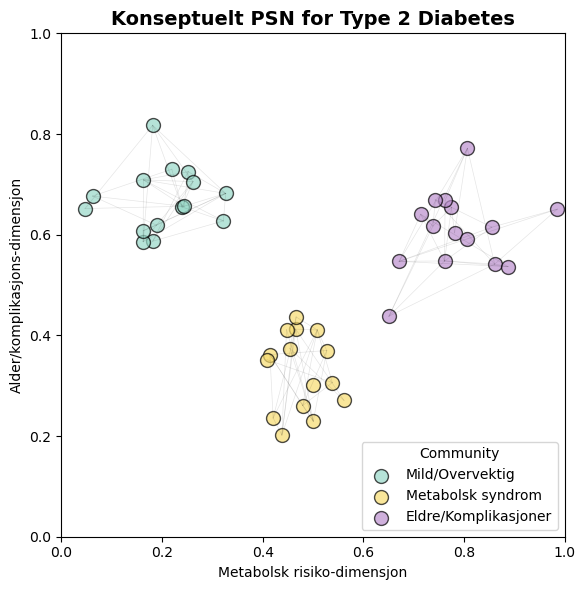

In [11]:
# Øvelse 3: Eksempel på klinisk PSN-design

print("="*70)
print("ØVELSE 3: Klinisk PSN-design - Type 2 Diabetes")
print("="*70)

clinical_scenario = """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
A) PASIENTPOPULASJON
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Voksne pasienter (18+ år) med nydiagnostisert Type 2 Diabetes
• Rekruttert fra primærhelsetjenesten
• n = 500-2000 pasienter for robust analyse

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
B) VARIABLER (minimum 5)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Kontinuerlige:
  1. HbA1c (%)                 - Langsiktig blodsukkerkontroll
  2. Fastende glukose (mmol/L) - Akutt metabolsk status
  3. BMI (kg/m²)               - Overvekt/fedme
  4. Blodtrykk (mmHg)          - Kardiovaskulær risiko
  5. Triglyserider (mmol/L)    - Lipidprofil
  6. eGFR (mL/min/1.73m²)      - Nyrefunksjon
  7. Alder (år)                - Demografisk

Kategoriske:
  8. Kjønn (M/K)
  9. Røykestatus (aldri/tidligere/aktiv)
  10. Fysisk aktivitetsnivå (lav/medium/høy)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
C) LIKHETSMÅL
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Gower distance er ideelt for blandede data:

  d_Gower(i,j) = (1/p) * Σ_k w_k * d_k(i,j)

der:
  • d_k(i,j) = |x_ik - x_jk| / range_k  for kontinuerlige
  • d_k(i,j) = 0 hvis x_ik == x_jk, 1 ellers  for kategoriske

Vekting av klinisk viktighet:
  • HbA1c: vekt = 2.0 (primært endepunkt)
  • BMI: vekt = 1.5 (viktig for behandlingsvalg)
  • Andre: vekt = 1.0

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
D) HVA COMMUNITIES KAN REPRESENTERE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Basert på litteratur kan communities representere:

Community 1: "Mild diabetes, overvektig"
  • Moderat HbA1c (7-8%)
  • Høy BMI
  • God nyrefunksjon
  → Behandling: Livsstilsintervensjon + Metformin

Community 2: "Avansert metabolsk syndrom"
  • Høy HbA1c (>8%)
  • Hypertensjon
  • Dyslipidemi
  → Behandling: Aggressiv multifaktoriell behandling

Community 3: "Eldre med komplikasjoner"
  • Høyere alder
  • Redusert nyrefunksjon
  • Kardiovaskulær sykdom
  → Behandling: Forsiktig tilnærming, unngå hypoglykemi

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
E) VALIDERING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Intern validering:
  • Bootstrap-stabilitet av communities
  • Silhouette score for clusterkvalitet
  • Modularity score

Ekstern validering:
  • Sammenlign communities med kjente subtyper fra litteratur
  • Prediker behandlingsrespons (HbA1c-endring etter 6 mnd)
  • Prediker komplikasjoner (kardiovaskulære events)
  
Klinisk nytte:
  • Prospektiv studie: Tilpass behandling basert på community
  • Sammenlign utfall med standard behandling
"""

print(clinical_scenario)

# Visualiser et konseptuelt diagram
fig, ax = plt.subplots(figsize=(10, 6))

# Tegn konseptuelt PSN
np.random.seed(42)
n_patients = 50

# Simuler tre communities
comm_centers = {
    'Mild/Overvektig': (0.2, 0.7),
    'Metabolsk syndrom': (0.5, 0.3),
    'Eldre/Komplikasjoner': (0.8, 0.6)
}
comm_colors = {'Mild/Overvektig': '#98D8C8', 'Metabolsk syndrom': '#F7DC6F', 'Eldre/Komplikasjoner': '#BB8FCE'}

for comm_name, (cx, cy) in comm_centers.items():
    # Tegn pasienter i hver community
    # NB: Bruker x_pts/y_pts for å unngå å overskrive global y-variabel
    x_pts = np.random.normal(cx, 0.08, 15)
    y_pts = np.random.normal(cy, 0.08, 15)
    ax.scatter(x_pts, y_pts, c=comm_colors[comm_name], s=100, alpha=0.7, label=comm_name, edgecolors='black')
    
    # Tegn kanter innad i community
    for i in range(len(x_pts)):
        for j in range(i+1, len(x_pts)):
            if np.random.random() < 0.3:
                ax.plot([x_pts[i], x_pts[j]], [y_pts[i], y_pts[j]], 'k-', alpha=0.1, linewidth=0.5)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Metabolsk risiko-dimensjon")
ax.set_ylabel("Alder/komplikasjons-dimensjon")
ax.set_title("Konseptuelt PSN for Type 2 Diabetes", fontsize=14, fontweight='bold')
ax.legend(loc='lower right', title='Community')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


---
## Øvelse 4: Normaliser features

### Oppgave
Normaliser IRIS-features til z-skår og bygg nytt nettverk. Sammenlign med originalt.

### Løsning

Normalisering (standardisering) er kritisk når features har ulik skala. Uten normalisering vil features med stor range dominere avstands-beregningen.

For z-skår normalisering transformerer vi hver feature slik at:
- Gjennomsnitt = 0
- Standardavvik = 1


ØVELSE 4: Feature-normalisering

Original feature-statistikk:
--------------------------------------------------
sepal length (cm)        : mean=5.84, std=0.83, range=[4.30, 7.90]
sepal width (cm)         : mean=3.06, std=0.43, range=[2.00, 4.40]
petal length (cm)        : mean=3.76, std=1.76, range=[1.00, 6.90]
petal width (cm)         : mean=1.20, std=0.76, range=[0.10, 2.50]

Normalisert feature-statistikk:
--------------------------------------------------
sepal length (cm)        : mean=-0.00, std=1.00, range=[-1.87, 2.49]
sepal width (cm)         : mean=-0.00, std=1.00, range=[-2.43, 3.09]
petal length (cm)        : mean=-0.00, std=1.00, range=[-1.57, 1.79]
petal width (cm)         : mean=-0.00, std=1.00, range=[-1.45, 1.71]

SAMMENLIGNING: Original vs. Normalisert

Original:
  • ARI: 0.5609
  • NMI: 0.7098
  • Antall communities: 3

Normalisert:
  • ARI: 0.6402
  • NMI: 0.7087
  • Antall communities: 3


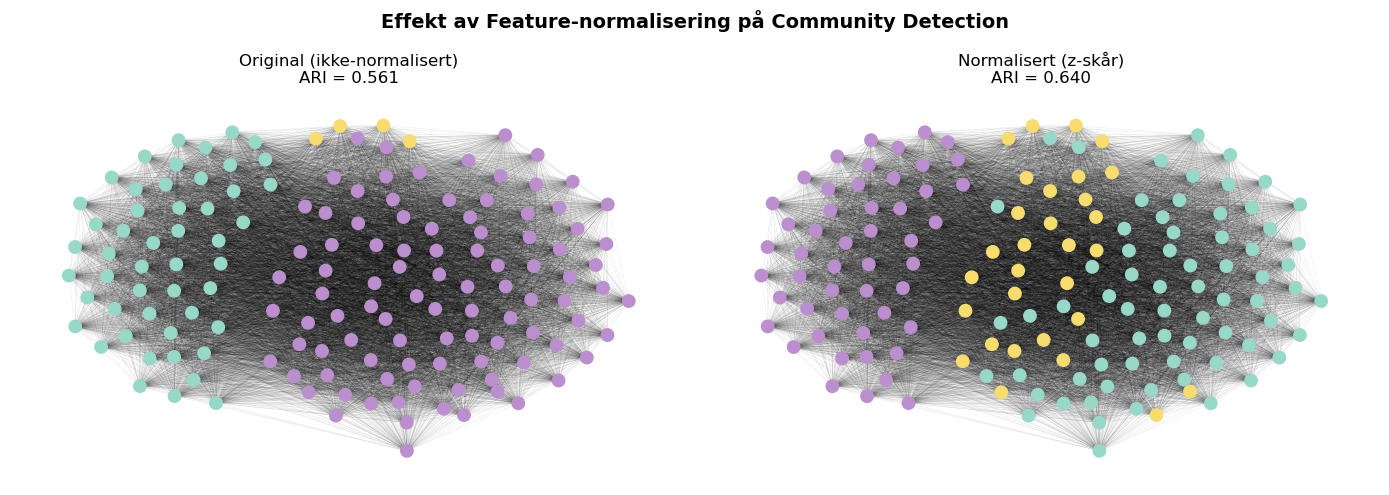


KONKLUSJON:
For IRIS-data er effekten av normalisering moderat fordi alle features 
allerede er i samme enhet (cm) og lignende range.

I kliniske data der variabler har vidt forskjellig skala (alder: 0-100, 
blodtrykk: 60-200, BMI: 15-50, HbA1c: 4-14) er normalisering KRITISK
for å unngå at én variabel dominerer likhetsmålet.



In [12]:
# Øvelse 4: Feature-normalisering

# Sikre at y er korrekt (kan bli overskrevet ved feil i tidligere celler)
y = iris.target

print("="*60)
print("ØVELSE 4: Feature-normalisering")
print("="*60)

# Vis original feature-statistikk
feature_names = iris.feature_names
print("\nOriginal feature-statistikk:")
print("-" * 50)
for i, name in enumerate(feature_names):
    print(f"{name:25s}: mean={X[:,i].mean():.2f}, std={X[:,i].std():.2f}, range=[{X[:,i].min():.2f}, {X[:,i].max():.2f}]")

# Normaliser med StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print("\nNormalisert feature-statistikk:")
print("-" * 50)
for i, name in enumerate(feature_names):
    print(f"{name:25s}: mean={X_normalized[:,i].mean():.2f}, std={X_normalized[:,i].std():.2f}, range=[{X_normalized[:,i].min():.2f}, {X_normalized[:,i].max():.2f}]")

# Bygg nettverk med normaliserte data
G_normalized = nx.Graph()
for i in range(len(X_normalized)):
    G_normalized.add_node(i, species=species[y[i]])

for i in range(len(X_normalized)):
    for j in range(i+1, len(X_normalized)):
        distance = np.linalg.norm(X_normalized[i] - X_normalized[j])
        similarity = 1 / (1.0 + distance)
        G_normalized.add_edge(i, j, weight=similarity)

# Community detection på normalisert nettverk
communities_normalized = community_louvain.best_partition(G_normalized)

# Sammenlign resultater
print("\n" + "="*60)
print("SAMMENLIGNING: Original vs. Normalisert")
print("="*60)

ari_original = adjusted_rand_score(y, list(communities_original.values()))
ari_normalized = adjusted_rand_score(y, list(communities_normalized.values()))

nmi_original = normalized_mutual_info_score(y, list(communities_original.values()))
nmi_normalized = normalized_mutual_info_score(y, list(communities_normalized.values()))

print(f"\nOriginal:")
print(f"  • ARI: {ari_original:.4f}")
print(f"  • NMI: {nmi_original:.4f}")
print(f"  • Antall communities: {len(set(communities_original.values()))}")

print(f"\nNormalisert:")
print(f"  • ARI: {ari_normalized:.4f}")
print(f"  • NMI: {nmi_normalized:.4f}")
print(f"  • Antall communities: {len(set(communities_normalized.values()))}")

# Visualiser sammenligning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (title, comm_dict, G_plot) in enumerate([
    ("Original (ikke-normalisert)", communities_original, G),
    ("Normalisert (z-skår)", communities_normalized, G_normalized)
]):
    ax = axes[idx]
    
    # Bruk community-farger
    comm_colors_plot = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
    color_map = [comm_colors_plot.get(comm_dict[n], 'gray') for n in G_plot.nodes()]
    
    nx.draw_networkx_nodes(G_plot, pos, node_color=color_map, node_size=80, ax=ax)
    nx.draw_networkx_edges(G_plot, pos, alpha=0.1, width=0.3, ax=ax)
    
    ari = adjusted_rand_score(y, list(comm_dict.values()))
    ax.set_title(f"{title}\nARI = {ari:.3f}", fontsize=12)
    ax.axis('off')

plt.suptitle("Effekt av Feature-normalisering på Community Detection", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
KONKLUSJON:
For IRIS-data er effekten av normalisering moderat fordi alle features 
allerede er i samme enhet (cm) og lignende range.

I kliniske data der variabler har vidt forskjellig skala (alder: 0-100, 
blodtrykk: 60-200, BMI: 15-50, HbA1c: 4-14) er normalisering KRITISK
for å unngå at én variabel dominerer likhetsmålet.
""")


---
## Øvelse 5: Sammenlign med K-means

### Oppgave
Kjør K-means clustering (k=3) og sammenlign med community detection.

### Løsning

K-means og community detection er begge metoder for å finne grupper i data, men de fungerer fundamentalt forskjellig:

| Aspekt | K-means | Community Detection |
|--------|---------|---------------------|
| Input | Feature-matrise | Graf/nettverk |
| Antall clusters | Må spesifiseres | Automatisk |
| Form | Sfæriske clustere | Vilkårlig form |
| Prinsipp | Minimere intra-cluster varians | Maksimere modularity |


ØVELSE 5: K-means vs. Community Detection

K-means (k=3):
  • Adjusted Rand Index: 0.7302
  • Normalized Mutual Information: 0.7582

Community Detection (Louvain):
  • Adjusted Rand Index: 0.5609
  • Normalized Mutual Information: 0.7098
  • Antall communities funnet: 3


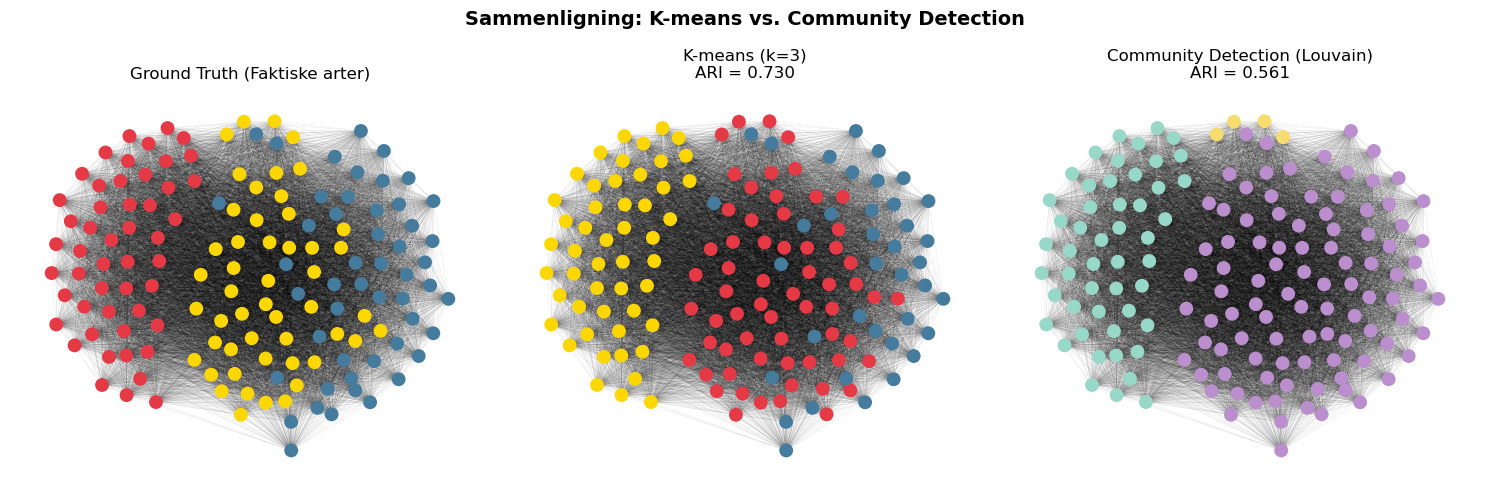


DETALJERT SAMMENLIGNING

K-means forvirringsmatrise (rader=faktisk art, kolonner=cluster):
            Cluster 0  Cluster 1  Cluster 2
setosa              0         50          0
versicolor         48          0          2
virginica          14          0         36

Community detection forvirringsmatrise:
            Community 0  Community 1  Community 2
setosa               50            0            0
versicolor            0            4           46
virginica             0            0           50

KONKLUSJON:
K-means og community detection gir ofte sammenlignbare resultater for IRIS-data.

STYRKER K-means:
• Enkel og rask
• Deterministisk med fast seed
• Lett å forstå

STYRKER Community Detection:
• Finner automatisk antall grupper
• Kan finne ikke-sfæriske clustere
• Naturlig for nettverksdata
• Kan bruke similarity-informasjon direkte



In [13]:
# Øvelse 5: K-means vs. Community Detection

# Sikre at y er korrekt (kan bli overskrevet ved feil i tidligere celler)
y = iris.target

print("="*60)
print("ØVELSE 5: K-means vs. Community Detection")
print("="*60)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Evalueringsmetrikker
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y, kmeans_labels)

ari_community = adjusted_rand_score(y, list(communities_original.values()))
nmi_community = normalized_mutual_info_score(y, list(communities_original.values()))

print("\nK-means (k=3):")
print(f"  • Adjusted Rand Index: {ari_kmeans:.4f}")
print(f"  • Normalized Mutual Information: {nmi_kmeans:.4f}")

print("\nCommunity Detection (Louvain):")
print(f"  • Adjusted Rand Index: {ari_community:.4f}")
print(f"  • Normalized Mutual Information: {nmi_community:.4f}")
print(f"  • Antall communities funnet: {len(set(communities_original.values()))}")

# Visualiser begge metoder
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ground truth
ax1 = axes[0]
color_map_true = [species_colors[species[y[i]]] for i in range(len(y))]
nx.draw_networkx_nodes(G, pos, node_color=color_map_true, node_size=80, ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax1)
ax1.set_title("Ground Truth (Faktiske arter)", fontsize=12)
ax1.axis('off')

# K-means
ax2 = axes[1]
kmeans_colors = {0: '#E63946', 1: '#FFD700', 2: '#457B9D'}
color_map_kmeans = [kmeans_colors[kmeans_labels[i]] for i in range(len(kmeans_labels))]
nx.draw_networkx_nodes(G, pos, node_color=color_map_kmeans, node_size=80, ax=ax2)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax2)
ax2.set_title(f"K-means (k=3)\nARI = {ari_kmeans:.3f}", fontsize=12)
ax2.axis('off')

# Community detection
ax3 = axes[2]
comm_colors_plot = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
color_map_comm = [comm_colors_plot.get(communities_original[n], 'gray') for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=color_map_comm, node_size=80, ax=ax3)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax3)
ax3.set_title(f"Community Detection (Louvain)\nARI = {ari_community:.3f}", fontsize=12)
ax3.axis('off')

plt.suptitle("Sammenligning: K-means vs. Community Detection", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Detaljert sammenligning
print("\n" + "="*60)
print("DETALJERT SAMMENLIGNING")
print("="*60)

# Lag forvirringsmatriser
from sklearn.metrics import confusion_matrix

# K-means forvirringsmatrise
print("\nK-means forvirringsmatrise (rader=faktisk art, kolonner=cluster):")
cm_kmeans = confusion_matrix(y, kmeans_labels)
print(pd.DataFrame(cm_kmeans, 
                   index=['setosa', 'versicolor', 'virginica'],
                   columns=['Cluster 0', 'Cluster 1', 'Cluster 2']))

# Community detection forvirringsmatrise
community_labels = [communities_original[i] for i in range(len(y))]
print("\nCommunity detection forvirringsmatrise:")
cm_community = confusion_matrix(y, community_labels)
print(pd.DataFrame(cm_community,
                   index=['setosa', 'versicolor', 'virginica'],
                   columns=[f'Community {i}' for i in range(cm_community.shape[1])]))

print("""
KONKLUSJON:
K-means og community detection gir ofte sammenlignbare resultater for IRIS-data.

STYRKER K-means:
• Enkel og rask
• Deterministisk med fast seed
• Lett å forstå

STYRKER Community Detection:
• Finner automatisk antall grupper
• Kan finne ikke-sfæriske clustere
• Naturlig for nettverksdata
• Kan bruke similarity-informasjon direkte
""")


---
## Øvelse 6: Sentralitetsanalyse

### Oppgave
Finn de mest "sentrale" blomstene med degree centrality og eigenvector centrality.

### Løsning

Sentralitetsmål forteller oss hvor "viktig" eller "sentral" en node er i nettverket:

- **Degree centrality**: Hvor mange kanter har noden? (vektet: sum av kantvekter)
- **Eigenvector centrality**: Er noden koblet til andre viktige noder?

I PSN kan sentrale pasienter representere "typiske" pasienter som ligner mange andre.


ØVELSE 6: Sentralitetsanalyse - Finn 'hub-blomster'

------------------------------------------------------------
TOPP 5 MEST SENTRALE BLOMSTER PER ART
------------------------------------------------------------

SETOSA:
    Node  Degree Cent   Eigen Cent Weighted Deg
  ------ ------------ ------------ ------------
       7       1.0000       0.0797        54.46
      39       1.0000       0.0796        54.40
      26       1.0000       0.0793        54.10
      17       1.0000       0.0788        53.89
      27       1.0000       0.0788        53.83

VERSICOLOR:
    Node  Degree Cent   Eigen Cent Weighted Deg
  ------ ------------ ------------ ------------
      78       1.0000       0.0968        61.72
      63       1.0000       0.0966        61.61
      91       1.0000       0.0964        61.50
      97       1.0000       0.0942        60.18
      54       1.0000       0.0940        60.06

VIRGINICA:
    Node  Degree Cent   Eigen Cent Weighted Deg
  ------ ------------ -----------

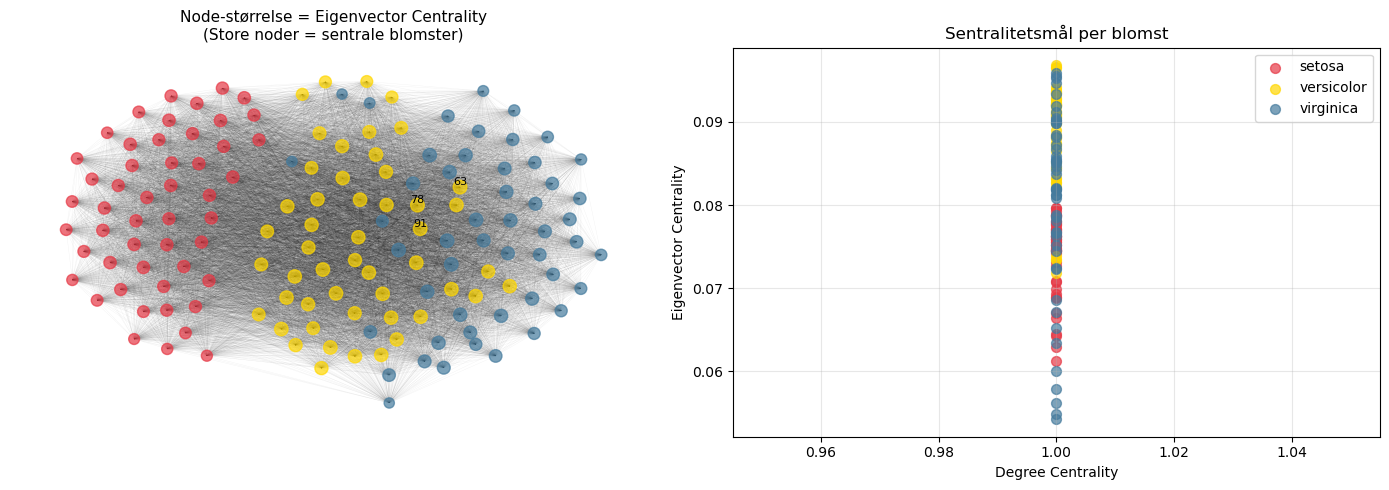


ER SENTRALE BLOMSTER 'TYPISKE'?

Gjennomsnittlige feature-verdier per art:
            sepal length (cm)  sepal width (cm)  petal length (cm)  \
setosa                  5.006             3.428              1.462   
versicolor              5.936             2.770              4.260   
virginica               6.588             2.974              5.552   

            petal width (cm)  
setosa                 0.246  
versicolor             1.326  
virginica              2.026  

Feature-verdier for mest sentrale blomst per art:

setosa (node 7):
  Features: [5.  3.4 1.5 0.2]
  Art-gjennomsnitt: [5.006 3.428 1.462 0.246]
  Avvik fra gjennomsnitt: [-0.006 -0.028  0.038 -0.046]

versicolor (node 78):
  Features: [6.  2.9 4.5 1.5]
  Art-gjennomsnitt: [5.936 2.77  4.26  1.326]
  Avvik fra gjennomsnitt: [0.064 0.13  0.24  0.174]

virginica (node 126):
  Features: [6.2 2.8 4.8 1.8]
  Art-gjennomsnitt: [6.588 2.974 5.552 2.026]
  Avvik fra gjennomsnitt: [-0.388 -0.174 -0.752 -0.226]

KONKLUSJON:

In [14]:
# Øvelse 6: Sentralitetsanalyse

# Sikre at y er korrekt
y = iris.target

print("="*60)
print("ØVELSE 6: Sentralitetsanalyse - Finn 'hub-blomster'")
print("="*60)

# Beregn sentralitetsmål
degree_cent = nx.degree_centrality(G)
eigen_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Beregn også vektet degree (sum av similarity til alle andre)
weighted_degree = {}
for node in G.nodes():
    weighted_degree[node] = sum([G[node][neighbor]['weight'] for neighbor in G.neighbors(node)])

# Finn topp 5 for hver art
print("\n" + "-"*60)
print("TOPP 5 MEST SENTRALE BLOMSTER PER ART")
print("-"*60)

for species_name in ['setosa', 'versicolor', 'virginica']:
    print(f"\n{species_name.upper()}:")
    
    # Filtrer noder for denne arten
    species_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == species_name]
    
    # Sorter etter eigenvector centrality
    top5 = sorted(species_nodes, key=lambda n: eigen_cent[n], reverse=True)[:5]
    
    print(f"  {'Node':>6} {'Degree Cent':>12} {'Eigen Cent':>12} {'Weighted Deg':>12}")
    print(f"  {'-'*6} {'-'*12} {'-'*12} {'-'*12}")
    for node in top5:
        print(f"  {node:>6} {degree_cent[node]:>12.4f} {eigen_cent[node]:>12.4f} {weighted_degree[node]:>12.2f}")

# Lag DataFrame for analyse
df_centrality = pd.DataFrame({
    'node': list(G.nodes()),
    'species': [G.nodes[n]['species'] for n in G.nodes()],
    'degree_centrality': [degree_cent[n] for n in G.nodes()],
    'eigenvector_centrality': [eigen_cent[n] for n in G.nodes()],
    'weighted_degree': [weighted_degree[n] for n in G.nodes()]
})

# Gjennomsnittlig sentralitet per art
print("\n" + "-"*60)
print("GJENNOMSNITTLIG SENTRALITET PER ART")
print("-"*60)
print(df_centrality.groupby('species')[['degree_centrality', 'eigenvector_centrality', 'weighted_degree']].mean().round(4))

# Visualiser sentralitet
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Eigenvector centrality som node-størrelse
ax1 = axes[0]
node_sizes = [eigen_cent[n] * 1000 for n in G.nodes()]
color_map = [species_colors[G.nodes[n]['species']] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=node_sizes, alpha=0.7, ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3, ax=ax1)

ax1.set_title("Node-størrelse = Eigenvector Centrality\n(Store noder = sentrale blomster)", fontsize=11)
ax1.axis('off')

# Marker topp 3 totalt
top3_overall = sorted(G.nodes(), key=lambda n: eigen_cent[n], reverse=True)[:3]
for node in top3_overall:
    x, y_pos = pos[node]
    ax1.annotate(f'{node}', (x, y_pos), fontsize=8, ha='center', va='bottom')

# Plot 2: Scatter av sentralitet per art
ax2 = axes[1]
for species_name in ['setosa', 'versicolor', 'virginica']:
    mask = df_centrality['species'] == species_name
    ax2.scatter(df_centrality.loc[mask, 'degree_centrality'],
               df_centrality.loc[mask, 'eigenvector_centrality'],
               c=species_colors[species_name], label=species_name, alpha=0.7, s=50)

ax2.set_xlabel('Degree Centrality')
ax2.set_ylabel('Eigenvector Centrality')
ax2.set_title('Sentralitetsmål per blomst')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Undersøk om sentrale noder er "typiske"
print("\n" + "="*60)
print("ER SENTRALE BLOMSTER 'TYPISKE'?")
print("="*60)

# Beregn gjennomsnitt for hver art
species_means = {}
for species_name in ['setosa', 'versicolor', 'virginica']:
    mask = y == list(iris.target_names).index(species_name)
    species_means[species_name] = X[mask].mean(axis=0)

print("\nGjennomsnittlige feature-verdier per art:")
print(pd.DataFrame(species_means, index=feature_names).T)

print("\nFeature-verdier for mest sentrale blomst per art:")
for species_name in ['setosa', 'versicolor', 'virginica']:
    species_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == species_name]
    most_central = max(species_nodes, key=lambda n: eigen_cent[n])
    print(f"\n{species_name} (node {most_central}):")
    print(f"  Features: {X[most_central]}")
    print(f"  Art-gjennomsnitt: {species_means[species_name]}")
    print(f"  Avvik fra gjennomsnitt: {X[most_central] - species_means[species_name]}")

print("""
KONKLUSJON:
De mest sentrale nodene har feature-verdier nær art-gjennomsnittet.
Dette betyr at sentrale blomster er "typiske" representanter for sin art.

I klinisk sammenheng: Sentrale pasienter kan brukes til å definere
"typiske" pasientprofiler for hver community/subtype.
""")


---
## Øvelse 7: Visualiser kun en art (sub-nettverk)

### Oppgave
Ekstraher sub-nettverk for en art og se om det finnes sub-communities innad.

### Løsning

Å analysere sub-nettverk er nyttig for å finne heterogenitet innad i en gruppe. I klinisk sammenheng kan dette avsløre sub-typer av en sykdom.


ØVELSE 7: Sub-nettverk analyse per art

SETOSA sub-nettverk:
  • Noder: 50
  • Kanter: 1225
  • Tetthet: 1.0000
  • Sub-communities funnet: 2
  • Modularity: 0.0389
  • Community-størrelser: {0: np.int64(28), 1: np.int64(22)}

VERSICOLOR sub-nettverk:
  • Noder: 50
  • Kanter: 1225
  • Tetthet: 1.0000
  • Sub-communities funnet: 2
  • Modularity: 0.0580
  • Community-størrelser: {0: np.int64(23), 1: np.int64(27)}

VIRGINICA sub-nettverk:
  • Noder: 50
  • Kanter: 1225
  • Tetthet: 1.0000
  • Sub-communities funnet: 3
  • Modularity: 0.0514
  • Community-størrelser: {0: np.int64(16), 1: np.int64(21), 2: np.int64(13)}


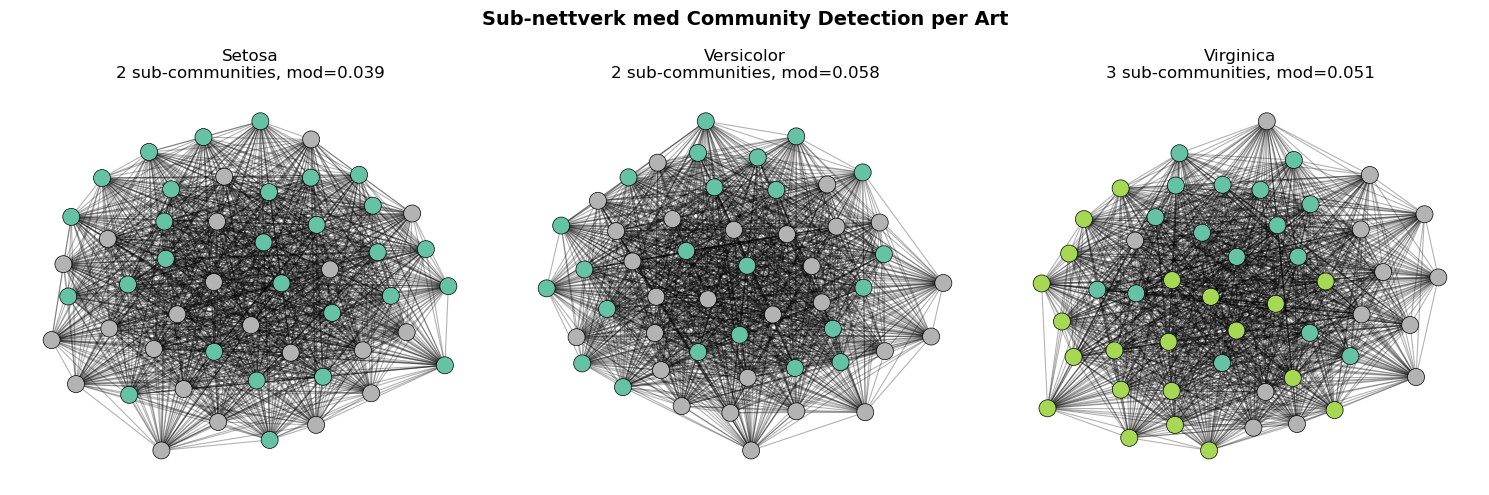


TOLKNING:
• Setosa: Homogen gruppe - typisk 1-2 sub-communities med lav modularity
• Versicolor: Moderat heterogenitet - kan deles i 2-3 sub-grupper
• Virginica: Lignende som versicolor

I klinisk sammenheng: Selv innenfor én diagnose kan det finnes 
relevante sub-typer basert på likhetsmønstre.



In [15]:
# Øvelse 7: Sub-nettverk analyse

print("="*60)
print("ØVELSE 7: Sub-nettverk analyse per art")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, species_name in enumerate(['setosa', 'versicolor', 'virginica']):
    # Finn noder for denne arten
    species_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == species_name]
    
    # Ekstraher sub-graf
    G_sub = G.subgraph(species_nodes).copy()
    
    # Community detection på sub-graf
    sub_communities = community_louvain.best_partition(G_sub)
    n_sub_comm = len(set(sub_communities.values()))
    
    # Beregn metrikker for sub-nettverket
    sub_density = nx.density(G_sub)
    sub_modularity = community_louvain.modularity(sub_communities, G_sub)
    
    print(f"\n{species_name.upper()} sub-nettverk:")
    print(f"  • Noder: {G_sub.number_of_nodes()}")
    print(f"  • Kanter: {G_sub.number_of_edges()}")
    print(f"  • Tetthet: {sub_density:.4f}")
    print(f"  • Sub-communities funnet: {n_sub_comm}")
    print(f"  • Modularity: {sub_modularity:.4f}")
    
    # Vis fordeling av sub-communities
    comm_counts = pd.Series(sub_communities).value_counts().sort_index()
    print(f"  • Community-størrelser: {dict(comm_counts)}")
    
    # Visualiser
    ax = axes[idx]
    
    # Lag layout for sub-graf
    pos_sub = nx.spring_layout(G_sub, k=0.5, seed=42)
    
    # Farger basert på sub-community
    sub_comm_colors = plt.cm.Set2(np.linspace(0, 1, n_sub_comm))
    color_map_sub = [sub_comm_colors[sub_communities[n]] for n in G_sub.nodes()]
    
    nx.draw_networkx_nodes(G_sub, pos_sub, node_color=color_map_sub, node_size=150, ax=ax, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G_sub, pos_sub, alpha=0.3, width=0.8, ax=ax)
    
    ax.set_title(f"{species_name.capitalize()}\n{n_sub_comm} sub-communities, mod={sub_modularity:.3f}")
    ax.axis('off')

plt.suptitle("Sub-nettverk med Community Detection per Art", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
TOLKNING:
• Setosa: Homogen gruppe - typisk 1-2 sub-communities med lav modularity
• Versicolor: Moderat heterogenitet - kan deles i 2-3 sub-grupper
• Virginica: Lignende som versicolor

I klinisk sammenheng: Selv innenfor én diagnose kan det finnes 
relevante sub-typer basert på likhetsmønstre.
""")


---
## Øvelse 8: Robusthetsanalyse

### Oppgave
Test hvor robust community detection er når vi fjerner tilfeldige noder.

### Løsning

I kliniske studier er data ofte ufullstendige. Robusthetsanalyse viser hvor stabile resultatene er når data mangler.


ØVELSE 8: Robusthetsanalyse

Tester robusthet ved å fjerne 0-50% av nodene (10 trials per nivå)...
------------------------------------------------------------
Fjernet    0%: ARI = 0.621 (std=0.029), Communities = 2.8 (std=0.4)
Fjernet   10%: ARI = 0.620 (std=0.029), Communities = 2.8 (std=0.4)
Fjernet   20%: ARI = 0.623 (std=0.037), Communities = 2.6 (std=0.5)
Fjernet   30%: ARI = 0.640 (std=0.074), Communities = 2.7 (std=0.5)
Fjernet   40%: ARI = 0.643 (std=0.055), Communities = 2.8 (std=0.4)
Fjernet   50%: ARI = 0.617 (std=0.109), Communities = 2.5 (std=0.5)


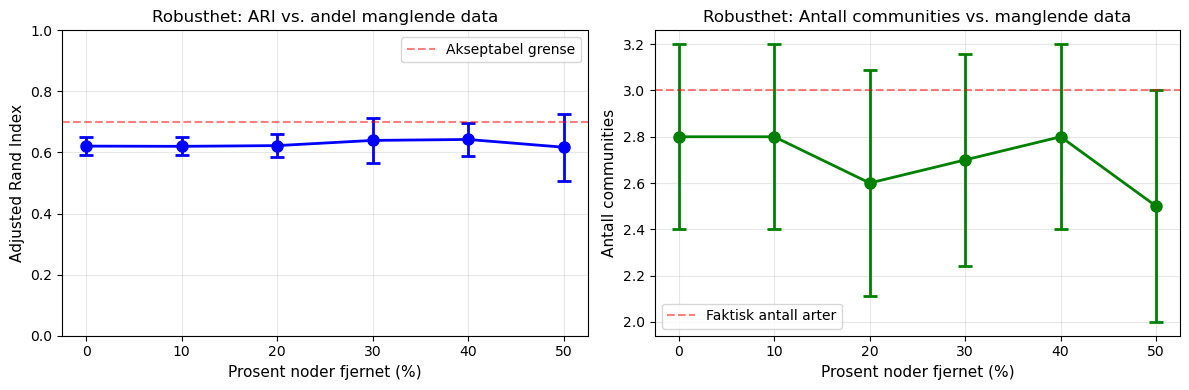


KONKLUSJON:
• Opp til ~20% manglende data: ARI holder seg relativt stabil
• Ved ~30%+ manglende data: Betydelig degradering
• Antall communities kan øke eller variere mer når data mangler

I praksis: Hvis mer enn 20-30% av pasientene mangler data, 
bør man vurdere imputation eller eksklusjonskriterier nøye.



In [16]:
# Øvelse 8: Robusthetsanalyse

# Sikre at y er korrekt
y = iris.target

print("="*60)
print("ØVELSE 8: Robusthetsanalyse")
print("="*60)

def test_robustness(G, y, remove_fraction, n_trials=10, seed=42):
    """
    Test robusthet ved å fjerne tilfeldige noder.
    
    Returns: gjennomsnittlig ARI og standardavvik
    """
    random.seed(seed)
    np.random.seed(seed)
    
    ari_scores = []
    n_communities_list = []
    
    for trial in range(n_trials):
        # Velg noder å beholde
        n_keep = int(len(G.nodes()) * (1 - remove_fraction))
        nodes_to_keep = random.sample(list(G.nodes()), n_keep)
        
        # Lag redusert graf
        G_reduced = G.subgraph(nodes_to_keep).copy()
        
        # Community detection
        if G_reduced.number_of_edges() > 0:
            communities_reduced = community_louvain.best_partition(G_reduced)
            n_comm = len(set(communities_reduced.values()))
            
            # Beregn ARI mot faktiske arter (kun for beholdte noder)
            y_kept = [y[n] for n in nodes_to_keep]
            labels_kept = [communities_reduced[n] for n in nodes_to_keep]
            ari = adjusted_rand_score(y_kept, labels_kept)
        else:
            ari = 0
            n_comm = n_keep
        
        ari_scores.append(ari)
        n_communities_list.append(n_comm)
    
    return {
        'mean_ari': np.mean(ari_scores),
        'std_ari': np.std(ari_scores),
        'mean_n_comm': np.mean(n_communities_list),
        'std_n_comm': np.std(n_communities_list)
    }

# Test med ulike fraksjoner
remove_fractions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
robustness_results = []

print("\nTester robusthet ved å fjerne 0-50% av nodene (10 trials per nivå)...")
print("-" * 60)

for frac in remove_fractions:
    result = test_robustness(G, y, frac, n_trials=10)
    result['remove_fraction'] = frac
    robustness_results.append(result)
    
    print(f"Fjernet {frac*100:4.0f}%: ARI = {result['mean_ari']:.3f} (std={result['std_ari']:.3f}), "
          f"Communities = {result['mean_n_comm']:.1f} (std={result['std_n_comm']:.1f})")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ARI vs remove fraction
ax1 = axes[0]
fracs = [r['remove_fraction']*100 for r in robustness_results]
aris = [r['mean_ari'] for r in robustness_results]
ari_stds = [r['std_ari'] for r in robustness_results]

ax1.errorbar(fracs, aris, yerr=ari_stds, fmt='bo-', capsize=5, capthick=2, linewidth=2, markersize=8)
ax1.set_xlabel('Prosent noder fjernet (%)', fontsize=11)
ax1.set_ylabel('Adjusted Rand Index', fontsize=11)
ax1.set_title('Robusthet: ARI vs. andel manglende data')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Akseptabel grense')
ax1.legend()

# Plot antall communities
ax2 = axes[1]
n_comms = [r['mean_n_comm'] for r in robustness_results]
n_comm_stds = [r['std_n_comm'] for r in robustness_results]

ax2.errorbar(fracs, n_comms, yerr=n_comm_stds, fmt='go-', capsize=5, capthick=2, linewidth=2, markersize=8)
ax2.set_xlabel('Prosent noder fjernet (%)', fontsize=11)
ax2.set_ylabel('Antall communities', fontsize=11)
ax2.set_title('Robusthet: Antall communities vs. manglende data')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=3, color='r', linestyle='--', alpha=0.5, label='Faktisk antall arter')
ax2.legend()

plt.tight_layout()
plt.show()

print("""
KONKLUSJON:
• Opp til ~20% manglende data: ARI holder seg relativt stabil
• Ved ~30%+ manglende data: Betydelig degradering
• Antall communities kan øke eller variere mer når data mangler

I praksis: Hvis mer enn 20-30% av pasientene mangler data, 
bør man vurdere imputation eller eksklusjonskriterier nøye.
""")


---
## Øvelse 9: Manhattan-avstand vs. Euklidsk

### Oppgave
Bytt ut Euklidsk avstand med Manhattan-avstand (L1-norm).

### Løsning

Manhattan-avstand (også kalt L1-norm eller "taxicab distance") summerer absolutte forskjeller:

$$d_{Manhattan}(x, y) = \sum_{i=1}^{n} |x_i - y_i|$$

Sammenlignet med Euklidsk avstand (L2-norm):

$$d_{Euklidsk}(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

Manhattan-avstand er mer robust mot uteliggere fordi den ikke kvadrerer forskjellene.


ØVELSE 9: Manhattan vs. Euklidsk avstand

Euklidsk avstand:
  • ARI: 0.6423
  • NMI: 0.7221
  • Communities: 3

Manhattan avstand:
  • ARI: 0.6423
  • NMI: 0.7221
  • Communities: 3


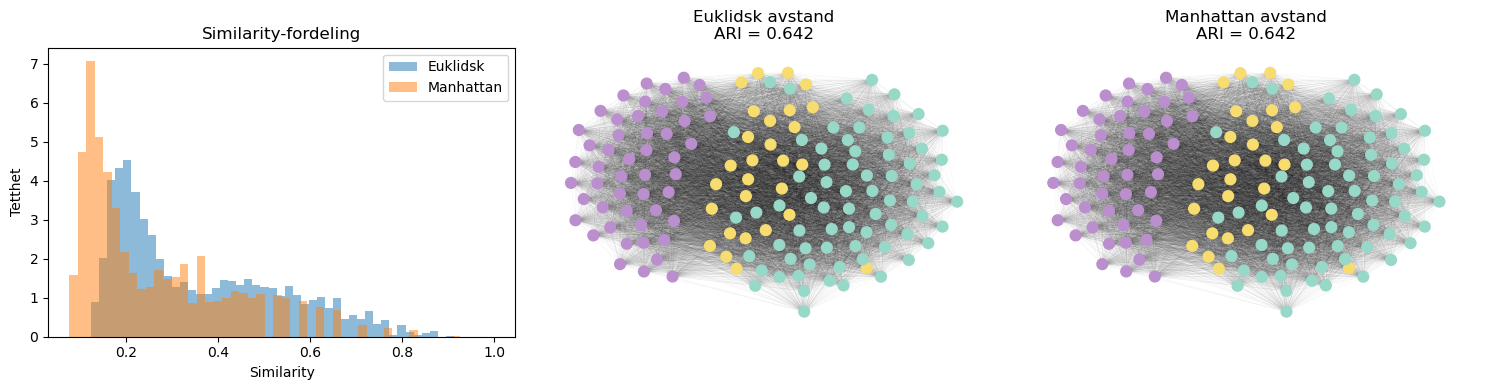


------------------------------------------------------------
ILLUSTRASJON: Euklidsk vs. Manhattan
------------------------------------------------------------

Punkt 1: [0 0]
Punkt 2: [3 4]
Euklidsk avstand: 5.00
Manhattan avstand: 7.00

KONKLUSJON:
For IRIS-data gir Euklidsk og Manhattan lignende resultater fordi:
• Dataene er rene (få uteliggere)
• Alle features er i samme enhet og skala

Manhattan-avstand er mer nyttig når:
• Data inneholder uteliggere
• Man ønsker å redusere påvirkning fra ekstreme verdier
• Features har ulik viktighet (samspiller med vekting)



In [17]:
# Øvelse 9: Manhattan vs. Euklidsk avstand

# Sikre at y er korrekt
y = iris.target

print("="*60)
print("ØVELSE 9: Manhattan vs. Euklidsk avstand")
print("="*60)

def build_network_with_distance(X, y, species, distance_func, name):
    """Bygg nettverk med gitt avstandsfunksjon."""
    G_new = nx.Graph()
    
    for i in range(len(X)):
        G_new.add_node(i, species=species[y[i]])
    
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            distance = distance_func(X[i], X[j])
            similarity = 1 / (1.0 + distance)
            G_new.add_edge(i, j, weight=similarity)
    
    return G_new

# Definer avstandsfunksjoner
def euclidean(x, y):
    return np.linalg.norm(x - y)

def manhattan(x, y):
    return cityblock(x, y)

# Bygg nettverk med begge metoder
G_euclidean = build_network_with_distance(X, y, species, euclidean, "Euclidean")
G_manhattan = build_network_with_distance(X, y, species, manhattan, "Manhattan")

# Community detection
comm_euclidean = community_louvain.best_partition(G_euclidean)
comm_manhattan = community_louvain.best_partition(G_manhattan)

# Evaluer
ari_euclidean = adjusted_rand_score(y, list(comm_euclidean.values()))
ari_manhattan = adjusted_rand_score(y, list(comm_manhattan.values()))

nmi_euclidean = normalized_mutual_info_score(y, list(comm_euclidean.values()))
nmi_manhattan = normalized_mutual_info_score(y, list(comm_manhattan.values()))

print("\nEuklidsk avstand:")
print(f"  • ARI: {ari_euclidean:.4f}")
print(f"  • NMI: {nmi_euclidean:.4f}")
print(f"  • Communities: {len(set(comm_euclidean.values()))}")

print("\nManhattan avstand:")
print(f"  • ARI: {ari_manhattan:.4f}")
print(f"  • NMI: {nmi_manhattan:.4f}")
print(f"  • Communities: {len(set(comm_manhattan.values()))}")

# Sammenlign similarity-fordelinger
sim_euclidean = [G_euclidean[u][v]['weight'] for u, v in G_euclidean.edges()]
sim_manhattan = [G_manhattan[u][v]['weight'] for u, v in G_manhattan.edges()]

# Visualiser
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Similarity-fordelinger
ax1 = axes[0]
ax1.hist(sim_euclidean, bins=50, alpha=0.5, label='Euklidsk', density=True)
ax1.hist(sim_manhattan, bins=50, alpha=0.5, label='Manhattan', density=True)
ax1.set_xlabel('Similarity')
ax1.set_ylabel('Tetthet')
ax1.set_title('Similarity-fordeling')
ax1.legend()

# Euclidean nettverk
ax2 = axes[1]
comm_colors_e = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
color_map_e = [comm_colors_e.get(comm_euclidean[n], 'gray') for n in G_euclidean.nodes()]
nx.draw_networkx_nodes(G_euclidean, pos, node_color=color_map_e, node_size=60, ax=ax2)
nx.draw_networkx_edges(G_euclidean, pos, alpha=0.05, width=0.3, ax=ax2)
ax2.set_title(f"Euklidsk avstand\nARI = {ari_euclidean:.3f}")
ax2.axis('off')

# Manhattan nettverk
ax3 = axes[2]
comm_colors_m = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
color_map_m = [comm_colors_m.get(comm_manhattan[n], 'gray') for n in G_manhattan.nodes()]
nx.draw_networkx_nodes(G_manhattan, pos, node_color=color_map_m, node_size=60, ax=ax3)
nx.draw_networkx_edges(G_manhattan, pos, alpha=0.05, width=0.3, ax=ax3)
ax3.set_title(f"Manhattan avstand\nARI = {ari_manhattan:.3f}")
ax3.axis('off')

plt.tight_layout()
plt.show()

# Illustrer forskjellen mellom avstandsmål
print("\n" + "-"*60)
print("ILLUSTRASJON: Euklidsk vs. Manhattan")
print("-"*60)

# Eksempel med to punkter
p1 = np.array([0, 0])
p2 = np.array([3, 4])

print(f"\nPunkt 1: {p1}")
print(f"Punkt 2: {p2}")
print(f"Euklidsk avstand: {euclidean(p1, p2):.2f}")
print(f"Manhattan avstand: {manhattan(p1, p2):.2f}")

print("""
KONKLUSJON:
For IRIS-data gir Euklidsk og Manhattan lignende resultater fordi:
• Dataene er rene (få uteliggere)
• Alle features er i samme enhet og skala

Manhattan-avstand er mer nyttig når:
• Data inneholder uteliggere
• Man ønsker å redusere påvirkning fra ekstreme verdier
• Features har ulik viktighet (samspiller med vekting)
""")


---
## Øvelse 10: Interaktiv terskel-slider

### Oppgave
Lag en interaktiv visualisering med ipywidgets der brukeren kan justere similarity-terskelen.

### Løsning

Interaktive visualiseringer er kraftige for utforskning og undervisning. Her bruker vi `ipywidgets` til å lage en slider.

**Merk:** Denne cellen fungerer best i Jupyter Notebook/Lab eller Google Colab. Den vil ikke fungere i statiske visninger.


In [18]:
# Øvelse 10: Interaktiv terskel-slider

print("="*60)
print("ØVELSE 10: Interaktiv terskel-slider")
print("="*60)

# Sjekk om ipywidgets er tilgjengelig
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets ikke installert. Installer med: pip install ipywidgets")

if WIDGETS_AVAILABLE:
    # Lag output-widget for plotting
    output = widgets.Output()
    
    def plot_network_with_threshold(threshold):
        """Tegn nettverk med kun kanter over gitt terskel."""
        with output:
            clear_output(wait=True)
            
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Filtrer kanter over terskel
            edges_to_show = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= threshold]
            weights_to_show = [G[u][v]['weight'] for u, v in edges_to_show]
            
            # Tegn noder (alltid)
            color_map = [species_colors[G.nodes[n]['species']] for n in G.nodes()]
            nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=80, ax=ax, edgecolors='black', linewidths=0.5)
            
            # Tegn kanter (kun over terskel)
            if len(edges_to_show) > 0:
                nx.draw_networkx_edges(G, pos, edgelist=edges_to_show, 
                                       edge_color=weights_to_show,
                                       edge_cmap=plt.cm.Blues,
                                       width=1.0, alpha=0.6, ax=ax)
            
            # Beregn metrikker
            max_edges = 150 * 149 // 2
            density = len(edges_to_show) / max_edges
            
            # Tittel med info
            ax.set_title(f"IRIS Likhetsnettverk\n"
                        f"Terskel: {threshold:.2f} | "
                        f"Kanter: {len(edges_to_show):,} ({density*100:.1f}%)", 
                        fontsize=12, fontweight='bold')
            
            # Legend
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                          label=s, markersize=10, markeredgecolor='black')
                for s, c in species_colors.items()
            ]
            ax.legend(handles=legend_elements, loc='upper right')
            ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n📊 Statistikk:")
            print(f"   • Terskel: {threshold:.2f}")
            print(f"   • Antall kanter vist: {len(edges_to_show):,} av {max_edges:,}")
            print(f"   • Nettverkstetthet: {density:.4f}")
    
    # Lag slider
    threshold_slider = widgets.FloatSlider(
        value=0.4,
        min=0.2,
        max=0.8,
        step=0.05,
        description='Terskel:',
        continuous_update=False,
        style={'description_width': '80px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Koble slider til funksjon
    interactive_plot = widgets.interactive_output(
        plot_network_with_threshold, 
        {'threshold': threshold_slider}
    )
    
    # Vis widget
    print("\n🎛️ Bruk slideren nedenfor til å justere similarity-terskelen:")
    print("   (Lavere terskel = flere kanter, høyere terskel = færre kanter)\n")
    display(threshold_slider)
    display(output)
    
    # Trigger initial plot
    plot_network_with_threshold(0.4)

else:
    # Fallback: Vis statiske plots for ulike terskler
    print("\nViser statiske plots for ulike terskler som alternativ...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    for idx, threshold in enumerate(thresholds):
        ax = axes[idx // 3, idx % 3]
        
        edges_to_show = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= threshold]
        weights_to_show = [G[u][v]['weight'] for u, v in edges_to_show]
        
        color_map = [species_colors[G.nodes[n]['species']] for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=40, ax=ax)
        
        if len(edges_to_show) > 0:
            nx.draw_networkx_edges(G, pos, edgelist=edges_to_show,
                                   alpha=0.4, width=0.5, ax=ax)
        
        n_edges = len(edges_to_show)
        density = n_edges / (150 * 149 // 2)
        ax.set_title(f"Terskel = {threshold}\n{n_edges:,} kanter ({density*100:.1f}%)")
        ax.axis('off')
    
    plt.suptitle("Effekt av ulike similarity-terskler", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("""
PEDAGOGISK VERDI:
Interaktive visualiseringer lar studenter utforske:
• Hvordan terskel påvirker nettverksstruktur
• Trade-off mellom komplett og glissent nettverk
• Når strukturer blir synlige vs. forsvinner

TIPS: Prøv å finne terskel-verdien der de tre art-klyngene 
akkurat begynner å separere seg!
""")


ØVELSE 10: Interaktiv terskel-slider



🎛️ Bruk slideren nedenfor til å justere similarity-terskelen:
   (Lavere terskel = flere kanter, høyere terskel = færre kanter)



FloatSlider(value=0.4, continuous_update=False, description='Terskel:', layout=Layout(width='400px'), max=0.8,…

Output()


PEDAGOGISK VERDI:
Interaktive visualiseringer lar studenter utforske:
• Hvordan terskel påvirker nettverksstruktur
• Trade-off mellom komplett og glissent nettverk
• Når strukturer blir synlige vs. forsvinner

TIPS: Prøv å finne terskel-verdien der de tre art-klyngene 
akkurat begynner å separere seg!



---
## Oppsummering

Gratulerer! Du har nå fullført alle 10 øvelser og fått praktisk erfaring med:

| Øvelse | Tema | Nøkkelinnsikt |
|--------|------|---------------|
| 1 | Gaussisk kjerne | Valg av σ påvirker nettverksstruktur drastisk |
| 2 | Glissne nettverk | Terskel-valg balanserer støy vs. informasjon |
| 3 | Klinisk design | PSN krever domenekunskap for meningsfull anvendelse |
| 4 | Normalisering | Kritisk for data med ulik skala |
| 5 | K-means | Community detection og clustering løser lignende problemer |
| 6 | Sentralitet | Sentrale noder er "typiske" representanter |
| 7 | Sub-nettverk | Heterogenitet kan finnes innad i grupper |
| 8 | Robusthet | Metoden tåler ~20-30% manglende data |
| 9 | Manhattan | Valg av avstandsmål påvirker resultater |
| 10 | Interaktivitet | Visualisering hjelper utforskning |

### Videre lesning

For å fordype deg i temaet, se:
- Pai & Bader (2018): "Patient Similarity Networks for Precision Medicine"
- Blondel et al. (2008): "Fast unfolding of communities in large networks"
- Gower (1971): "A General Coefficient of Similarity and Some of Its Properties"

### Neste steg

Gå videre til:
- `02b-pasient_likhetsnettverk_iris_utvidet.ipynb` – Utvidet versjon med blandede datatyper
- `03-...` – Syntetiske pasientdata
- `04-pasient_likhetsnettverk_IQ.ipynb` – Reelle data fra ABCD-studien
